In [7]:
!wget https://download.pytorch.org/tutorial/data.zip

--2022-01-06 07:20:56--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.32.204.49, 13.32.204.34, 13.32.204.93, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.32.204.49|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.04s   

2022-01-06 07:20:56 (74.8 MB/s) - ‘data.zip’ saved [2882130/2882130]



In [8]:
!unzip /content/data.zip

Archive:  /content/data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.txt  
  inflating: data/names/Japanese.txt  
  inflating: data/names/Korean.txt   
  inflating: data/names/Polish.txt   
  inflating: data/names/Portuguese.txt  
  inflating: data/names/Russian.txt  
  inflating: data/names/Scottish.txt  
  inflating: data/names/Spanish.txt  
  inflating: data/names/Vietnamese.txt  


In [9]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

#Turn a unicode string to plain ASCII
def unicodeToAscii(s):
  return ''.join(
      c for c in unicodedata.normalize('NFD',s)
      if unicodedata.category(c) != ' Mn'
      and c in all_letters
  )
print(unicodeToAscii('Ślusàrski'))

['data/names/English.txt', 'data/names/Scottish.txt', 'data/names/Chinese.txt', 'data/names/Polish.txt', 'data/names/Italian.txt', 'data/names/Vietnamese.txt', 'data/names/Dutch.txt', 'data/names/Korean.txt', 'data/names/Japanese.txt', 'data/names/Czech.txt', 'data/names/Russian.txt', 'data/names/Greek.txt', 'data/names/Arabic.txt', 'data/names/French.txt', 'data/names/Spanish.txt', 'data/names/Portuguese.txt', 'data/names/German.txt', 'data/names/Irish.txt']
Slusarski


In [12]:
#Build the category lines dictionary, a list of names per language
category_lines = {}
all_categories = []

#Read a file and split into names
def readlines(filename):
  lines = open(filename,encoding = 'utf-8').read().strip().split('\n')
  return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
  category = os.path.splitext(os.path.basename(filename))[0]
  all_categories.append(category)
  lines = readlines(filename)
  category_lines[category] = lines

n_categories = len(all_categories)
print(n_categories)

18


In [13]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [18]:
#Turning Names into tensors
import torch

def lettertoIndex(letter):
  return all_letters.find(letter)

def letterToTensor(letter):
  tensor = torch.zeros(1,n_letters)
  tensor[0][lettertoIndex(letter)] = 1
  return tensor
def lineToTensor(line):
  tensor = torch.zeros(len(line),1,n_letters)
  for li,letter in enumerate(line):
    tensor[li][0][lettertoIndex(letter)] = 1
  return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [25]:
#Creating the network
import torch.nn as nn

class RNN(nn.Module):
  def __init__(self,input_size,hidden_size,output_size):
    super(RNN,self).__init__()

    self.hidden_size = hidden_size
    self.i2h = nn.Linear(input_size+hidden_size,hidden_size)
    self.i2o = nn.Linear(input_size+hidden_size,output_size)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self,input, hidden):
    combined = torch.cat((input,hidden),1)
    hidden = self.i2h(combined)
    output = self.i2o(combined)
    output = self.softmax(output)
    return output,hidden
    
  def initHidden(self):
    return torch.zeros(1,self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters,n_hidden,n_categories)

In [26]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [31]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8779, -2.9247, -2.9105, -2.9387, -2.9005, -2.8997, -2.8067, -2.9494,
         -2.9319, -2.9404, -2.9539, -2.9420, -2.7615, -2.8556, -2.7837, -2.9156,
         -2.8857, -2.8767]], grad_fn=<LogSoftmaxBackward0>)


In [33]:
#Prepairing for the training
def categoryFromOutput(output):
  top_n, top_i = output.topk(1)
  category_i = top_i[0].item()
  return all_categories[category_i], category_i
print(categoryFromOutput(output))

('Arabic', 12)


In [35]:
import random
def randomChoice(l):
  return l[random.randint(0,len(l)-1)]

def randomTrainingExample():
  category = randomChoice(all_categories)
  line = randomChoice(category_lines[category])
  category_tensor = torch.tensor([all_categories.index(category)],dtype=torch.long)
  line_tensor = lineToTensor(line)
  return category, line, category_tensor, line_tensor

for i in range(10):
  category,line,category_tensor,line_tensor = randomTrainingExample()
  print('category = ',category,' / line =',line)

category =  Polish  / line = Kowalczyk
category =  Polish  / line = Grzeskiewicz
category =  Dutch  / line = Agthoven
category =  Greek  / line = Avgerinos
category =  French  / line = Rey
category =  Vietnamese  / line = an
category =  Italian  / line = Nardo
category =  German  / line = Eberhardt
category =  Japanese  / line = Masuno
category =  Greek  / line = Christakos


In [36]:
#Training the network
criterion = nn.NLLLoss()

**Each loop of training will:**

    * Create input and target tensors

    * Create a zeroed initial hidden state

    * Read each letter in and
        Keep hidden state for next letter

    * Compare final output to target

    * Back-propagate

    * Return the output and loss







In [44]:
learning_rate = 0.005
def train(category_tensor,line_tensor):
  hidden = rnn.initHidden()

  rnn.zero_grad()

  for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i],hidden)
  
  loss = criterion(output,category_tensor)
  loss.backward()

  #Add parameters gradients to their values, multiplied by learning rate
  for p in rnn.parameters():
    p.data.add_(p.grad.data, alpha=-learning_rate)
  
  return output, loss.item()


In [45]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0


5000 5% (0m 5s) 2.6934 Gashkin / Scottish ✗ (Russian)
10000 10% (0m 10s) 1.6080 Huynh / Vietnamese ✓
15000 15% (0m 15s) 0.7332 Vlahos / Greek ✓
20000 20% (0m 21s) 2.8864 Rackham / Irish ✗ (English)
25000 25% (0m 26s) 2.3658 Lightfoot / Russian ✗ (English)
30000 30% (0m 32s) 0.7370 Meeuwissen / Dutch ✓
35000 35% (0m 37s) 0.7824 Cho / Korean ✓
40000 40% (0m 42s) 0.5814 Matsumara / Japanese ✓
45000 45% (0m 48s) 0.7896 Klimek / Polish ✓
50000 50% (0m 53s) 0.3114 You / Korean ✓
55000 55% (0m 59s) 0.5587 Kuijpers / Dutch ✓
60000 60% (1m 4s) 4.9212 Lis / Chinese ✗ (Polish)
65000 65% (1m 10s) 1.4025 Bhrighde / Japanese ✗ (Irish)
70000 70% (1m 15s) 0.6936 Schneijder / Dutch ✓
75000 75% (1m 21s) 0.2384 Thao / Vietnamese ✓
80000 80% (1m 26s) 1.6746 Lenz / Chinese ✗ (German)
85000 85% (1m 31s) 0.1707 Yao / Chinese ✓
90000 90% (1m 37s) 2.2038 Whelan / Scottish ✗ (Irish)
95000 95% (1m 42s) 2.0060 Augustin / Russian ✗ (French)
100000 100% (1m 47s) 2.1651 Rong / Korean ✗ (Chinese)


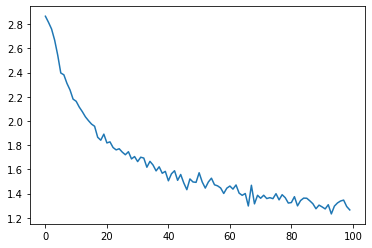

In [46]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

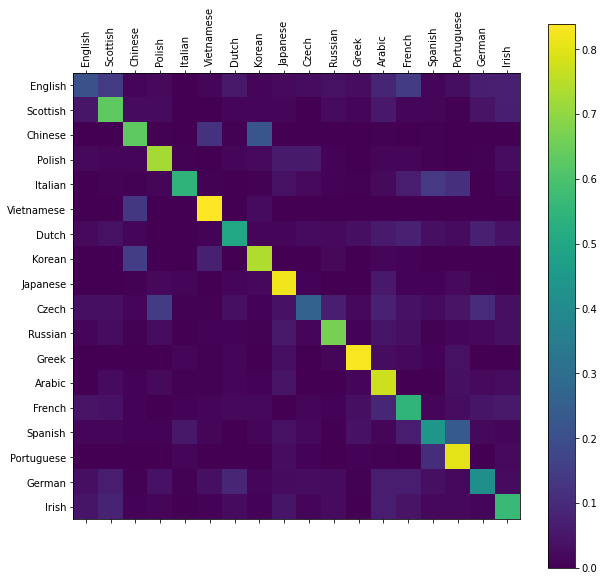

In [49]:
#Let's evaluate the results

confusion = torch.zeros(n_categories,n_categories)
n_confusion = 10000

#Return an output given a line
def evaluate(line_tensor):
  hidden = rnn.initHidden()

  for i in range(line_tensor.size()[0]):
    output, hidden = rnn(line_tensor[i],hidden)
  return output

#Go through a bunch of examples and see which is correctly  guessed
for i in range(n_confusion):
  category, line, category_tensor, line_tensor = randomTrainingExample()
  output = evaluate(line_tensor)
  guess, guess_i = categoryFromOutput(output)
  category_i = all_categories.index(category)
  confusion[category_i][guess_i] +=1


# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [50]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.38) Russian
(-1.50) Czech
(-3.37) English

> Jackson
(-0.27) Scottish
(-2.16) English
(-2.83) Russian

> Satoshi
(-0.82) Arabic
(-1.39) Japanese
(-2.26) Polish
